In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

you will use Google Search results with the Gemini API in a technique called grounding, where the model is connected to verifiable sources of information. Using search grounding is similar to using the RAG system you implemented earlier in the week, but the Gemini API automates a lot of it for you. The model generates Google Search queries and invokes the searches automatically, retrieving relevant data from Google's index of the web and providing links to search suggestions that support the query, so your users can verify the sources.

In [1]:
# Uninstall packages from Kaggle base image that are not needed.
!pip uninstall -qy jupyterlab jupyterlab-lsp
# Install the google-genai SDK for this codelab.
!pip install -qU 'google-genai==1.7.0'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 5.1 MB/s eta 0:00:00


In [2]:
from google import genai
from google.genai import types

from IPython.display import Markdown, HTML, display

genai.__version__

'1.7.0'

In [3]:
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")

client = genai.Client(api_key=GOOGLE_API_KEY)

In [4]:
# Define a retry policy. The model might make multiple consecutive calls automatically
# for a complex query, this ensures the client retries if it hits quota limits.
from google.api_core import retry

is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

if not hasattr(genai.models.Models.generate_content, '__wrapped__'):
  genai.models.Models.generate_content = retry.Retry(
      predicate=is_retriable)(genai.models.Models.generate_content)

**Use search grounding**

In [5]:
# Ask for information without search grounding.
response = client.models.generate_content(
    model='gemini-2.0-flash',
    contents="When and where is Billie Eilish's next concert?")

Markdown(response.text)

Unfortunately, I cannot give you precise, up-to-the-minute information on Billie Eilish's concert schedule. Concert dates change, and I do not have access to a live, updated concert database.

However, I can provide you with the best places to find this information:

*   **Billie Eilish's Official Website:** This is the most reliable source. Look for a "Tour" or "Events" section.
*   **Ticketmaster, Live Nation, or other major ticketing websites:** Check these sites; they will list confirmed tour dates and allow you to purchase tickets.
*   **Bandsintown:** This website/app is great for tracking artists and receiving notifications when they announce shows near you.
*   **Google Search:** Search for "Billie Eilish tour dates" or "Billie Eilish concerts" to see recent news and listings.
*   **Billie Eilish's Social Media:** Follow Billie Eilish on social media platforms (Instagram, Twitter/X, Facebook) for announcements.

**Now try with grounding enabled**

In [6]:
# And now re-run the same query with search grounding enabled.
config_with_search = types.GenerateContentConfig(
    tools=[types.Tool(google_search=types.GoogleSearch())],
)

def query_with_grounding():
    response = client.models.generate_content(
        model='gemini-2.0-flash',
        contents="When and where is Billie Eilish's next concert?",
        config=config_with_search,
    )
    return response.candidates[0]


rc = query_with_grounding()
Markdown(rc.content.parts[0].text)

Billie Eilish's next concert is on Wednesday, April 23, 2025, at the Avicii Arena in Stockholm, Sweden. She also has another concert at the same location the following day, Thursday, April 24, 2025.


Response metadata

When search grounding is used, the model returns extra metadata that includes links to search suggestions, supporting documents and information on how the supporting documents were used.

Each "grounding chunk" represents information retrieved from Google Search that was used in the grounded generation request. Following the URI will take you to the source

In [7]:
while not rc.grounding_metadata.grounding_supports or not rc.grounding_metadata.grounding_chunks:
    # If incomplete grounding data was returned, retry.
    rc = query_with_grounding()

chunks = rc.grounding_metadata.grounding_chunks
for chunk in chunks:
    print(f'{chunk.web.title}: {chunk.web.uri}')

ticketmaster.co.uk: https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAKOAs6M7MDopkwoX41xLtMUeM3mic0KsvyYKsFq-Go0V5851riImTeSFBMIHpVSUcWxWphEmP7Xm_zAYvXcNKuJhwTswS7haTWg_A3D_AAju8I9HRDp99yGYjXtJNvP6eHc4H7gjrOO_xfSH6Fxy2LFUeat79e1cLWzWR04kw==


In [8]:
HTML(rc.grounding_metadata.search_entry_point.rendered_content)

The grounding_supports in the metadata provide a way for you to correlate the grounding chunks used to the generated output text.

In [9]:
from pprint import pprint

supports = rc.grounding_metadata.grounding_supports
for support in supports:
    pprint(support.to_json_dict())

{'confidence_scores': [0.6152464],
 'grounding_chunk_indices': [0],
 'segment': {'end_index': 103,
             'text': "Billie Eilish's next concert is on Wednesday, April 23, "
                     '2025, at the Avicii Arena in Stockholm, Sweden.'}}
{'confidence_scores': [0.6027544],
 'grounding_chunk_indices': [0],
 'segment': {'end_index': 198,
             'start_index': 104,
             'text': 'She also has another concert at the same location the '
                     'following day, Thursday, April 24, 2025.'}}


In [10]:
import io

markdown_buffer = io.StringIO()

# Print the text with footnote markers.
markdown_buffer.write("Supported text:\n\n")
for support in supports:
    markdown_buffer.write(" * ")
    markdown_buffer.write(
        rc.content.parts[0].text[support.segment.start_index : support.segment.end_index]
    )

    for i in support.grounding_chunk_indices:
        chunk = chunks[i].web
        markdown_buffer.write(f"<sup>[{i+1}]</sup>")

    markdown_buffer.write("\n\n")


# And print the footnotes.
markdown_buffer.write("Citations:\n\n")
for i, chunk in enumerate(chunks, start=1):
    markdown_buffer.write(f"{i}. [{chunk.web.title}]({chunk.web.uri})\n")


Markdown(markdown_buffer.getvalue())

Supported text:

 * Billie Eilish's next concert is on Wednesday, April 23, 2025, at the Avicii Arena in Stockholm, Sweden.<sup>[1]</sup>

 * She also has another concert at the same location the following day, Thursday, April 24, 2025.<sup>[1]</sup>

Citations:

1. [ticketmaster.co.uk](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAKOAs6M7MDopkwoX41xLtMUeM3mic0KsvyYKsFq-Go0V5851riImTeSFBMIHpVSUcWxWphEmP7Xm_zAYvXcNKuJhwTswS7haTWg_A3D_AAju8I9HRDp99yGYjXtJNvP6eHc4H7gjrOO_xfSH6Fxy2LFUeat79e1cLWzWR04kw==)


Search with tools

In this example, you'll use enable the Google Search grounding tool and the code generation tool across two steps. In the first step, the model will use Google Search to find the requested information and then in the follow-up question, it generates code to plot the results.

This usage includes textual, visual and code parts, so first define a function to help visualise these.

In [12]:
from IPython.display import display, Image, Markdown

def show_response(response):
    for p in response.candidates[0].content.parts:
        if p.text:
            display(Markdown(p.text))
        elif p.inline_data:
            display(Image(p.inline_data.data))
        else:
            print(p.to_json_dict())
    
        display(Markdown('----'))

In [13]:
config_with_search = types.GenerateContentConfig(
    tools=[types.Tool(google_search=types.GoogleSearch())],
    temperature=0.0,
)

chat = client.chats.create(model='gemini-2.0-flash')

response = chat.send_message(
    message="What were the medal tallies, by top-10 countries, for the 2024 olympics?",
    config=config_with_search,
)

show_response(response)

Here are the top 10 countries by medal tally at the 2024 Paris Olympics:

1.  United States of America: 40 Gold, 44 Silver, 42 Bronze (126 total)
2.  People's Republic of China: 40 Gold, 27 Silver, 24 Bronze (91 total)
3.  Japan: 20 Gold, 12 Silver, 13 Bronze (45 total)
4.  Australia: 18 Gold, 19 Silver, 16 Bronze (53 total)
5.  France: 16 Gold, 26 Silver, 22 Bronze (64 total)
6.  Netherlands: 15 Gold, 7 Silver, 12 Bronze (34 total)
7.  Great Britain: 14 Gold, 22 Silver, 29 Bronze (65 total)
8.  Republic of Korea: 13 Gold, 9 Silver, 10 Bronze (32 total)
9.  Italy: 12 Gold, 13 Silver, 15 Bronze (40 total)
10. Germany: 12 Gold, 13 Silver, 8 Bronze (33 total)

----

Okay, I can help you visualize this data using a Seaborn chart. I'll use a stacked bar chart to represent the medal distribution for each country.



----

{'executable_code': {'code': 'import pandas as pd\nimport seaborn as sns\nimport matplotlib.pyplot as plt\n\n# Data from the previous response\ndata = {\n    \'Country\': [\'United States of America\', \'People\\\'s Republic of China\', \'Japan\', \'Australia\', \'France\', \'Netherlands\', \'Great Britain\', \'Republic of Korea\', \'Italy\', \'Germany\'],\n    \'Gold\': [40, 40, 20, 18, 16, 15, 14, 13, 12, 12],\n    \'Silver\': [44, 27, 12, 19, 26, 7, 22, 9, 13, 13],\n    \'Bronze\': [42, 24, 13, 16, 22, 12, 29, 10, 15, 8]\n}\n\ndf = pd.DataFrame(data)\ndf = df.set_index(\'Country\')\n\n# Plotting the stacked bar chart\nplt.figure(figsize=(12, 8))  # Adjust figure size for better readability\nsns.set_palette("viridis")  # Choose a color palette\n\ndf.plot(kind=\'bar\', stacked=True)\n\nplt.title(\'2024 Olympics Medal Tally (Top 10 Countries)\')\nplt.xlabel(\'Country\')\nplt.ylabel(\'Number of Medals\')\nplt.xticks(rotation=45, ha=\'right\')  # Rotate x-axis labels for readability\nplt

----

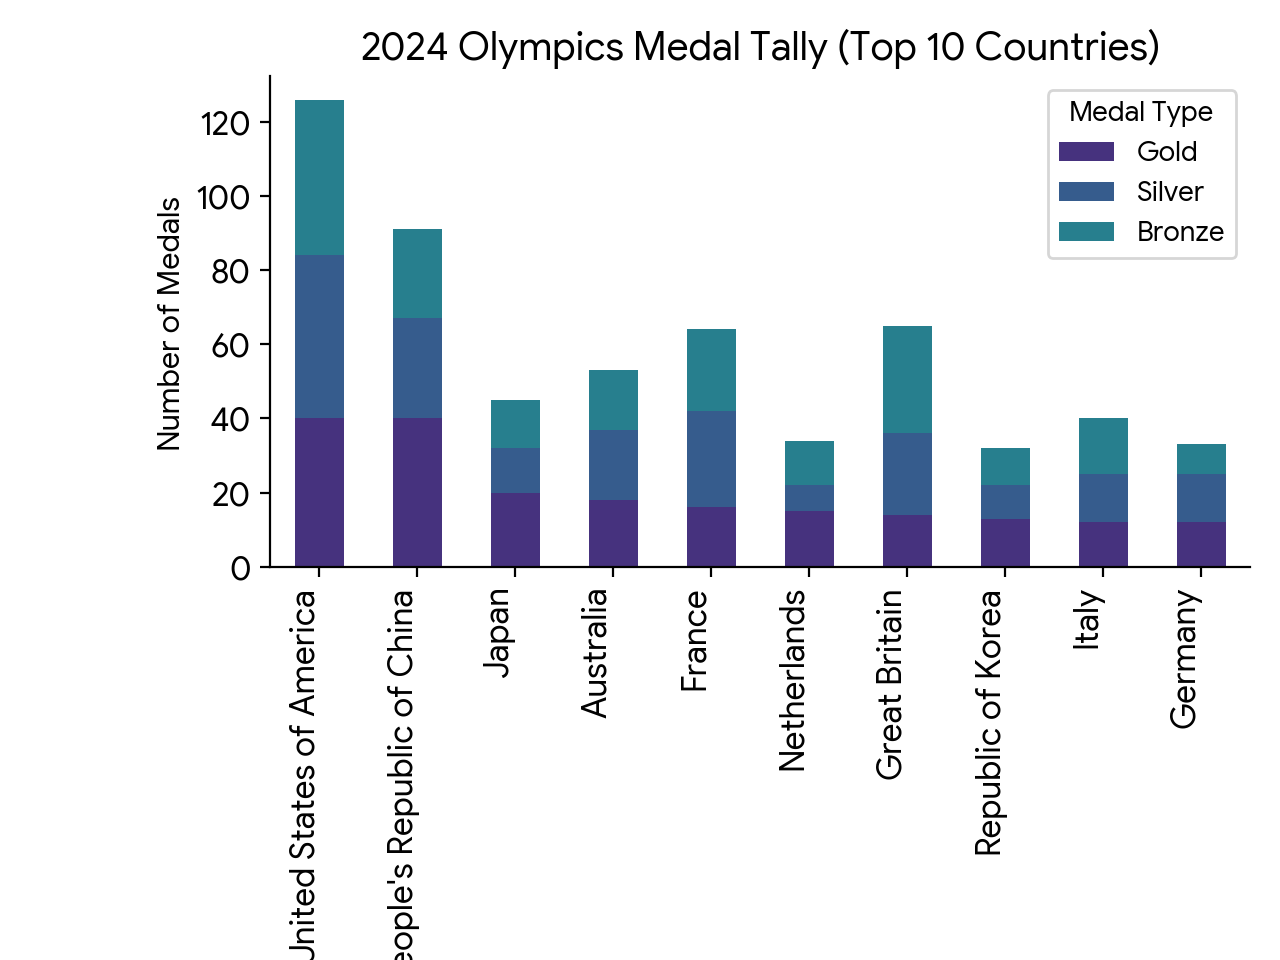

----

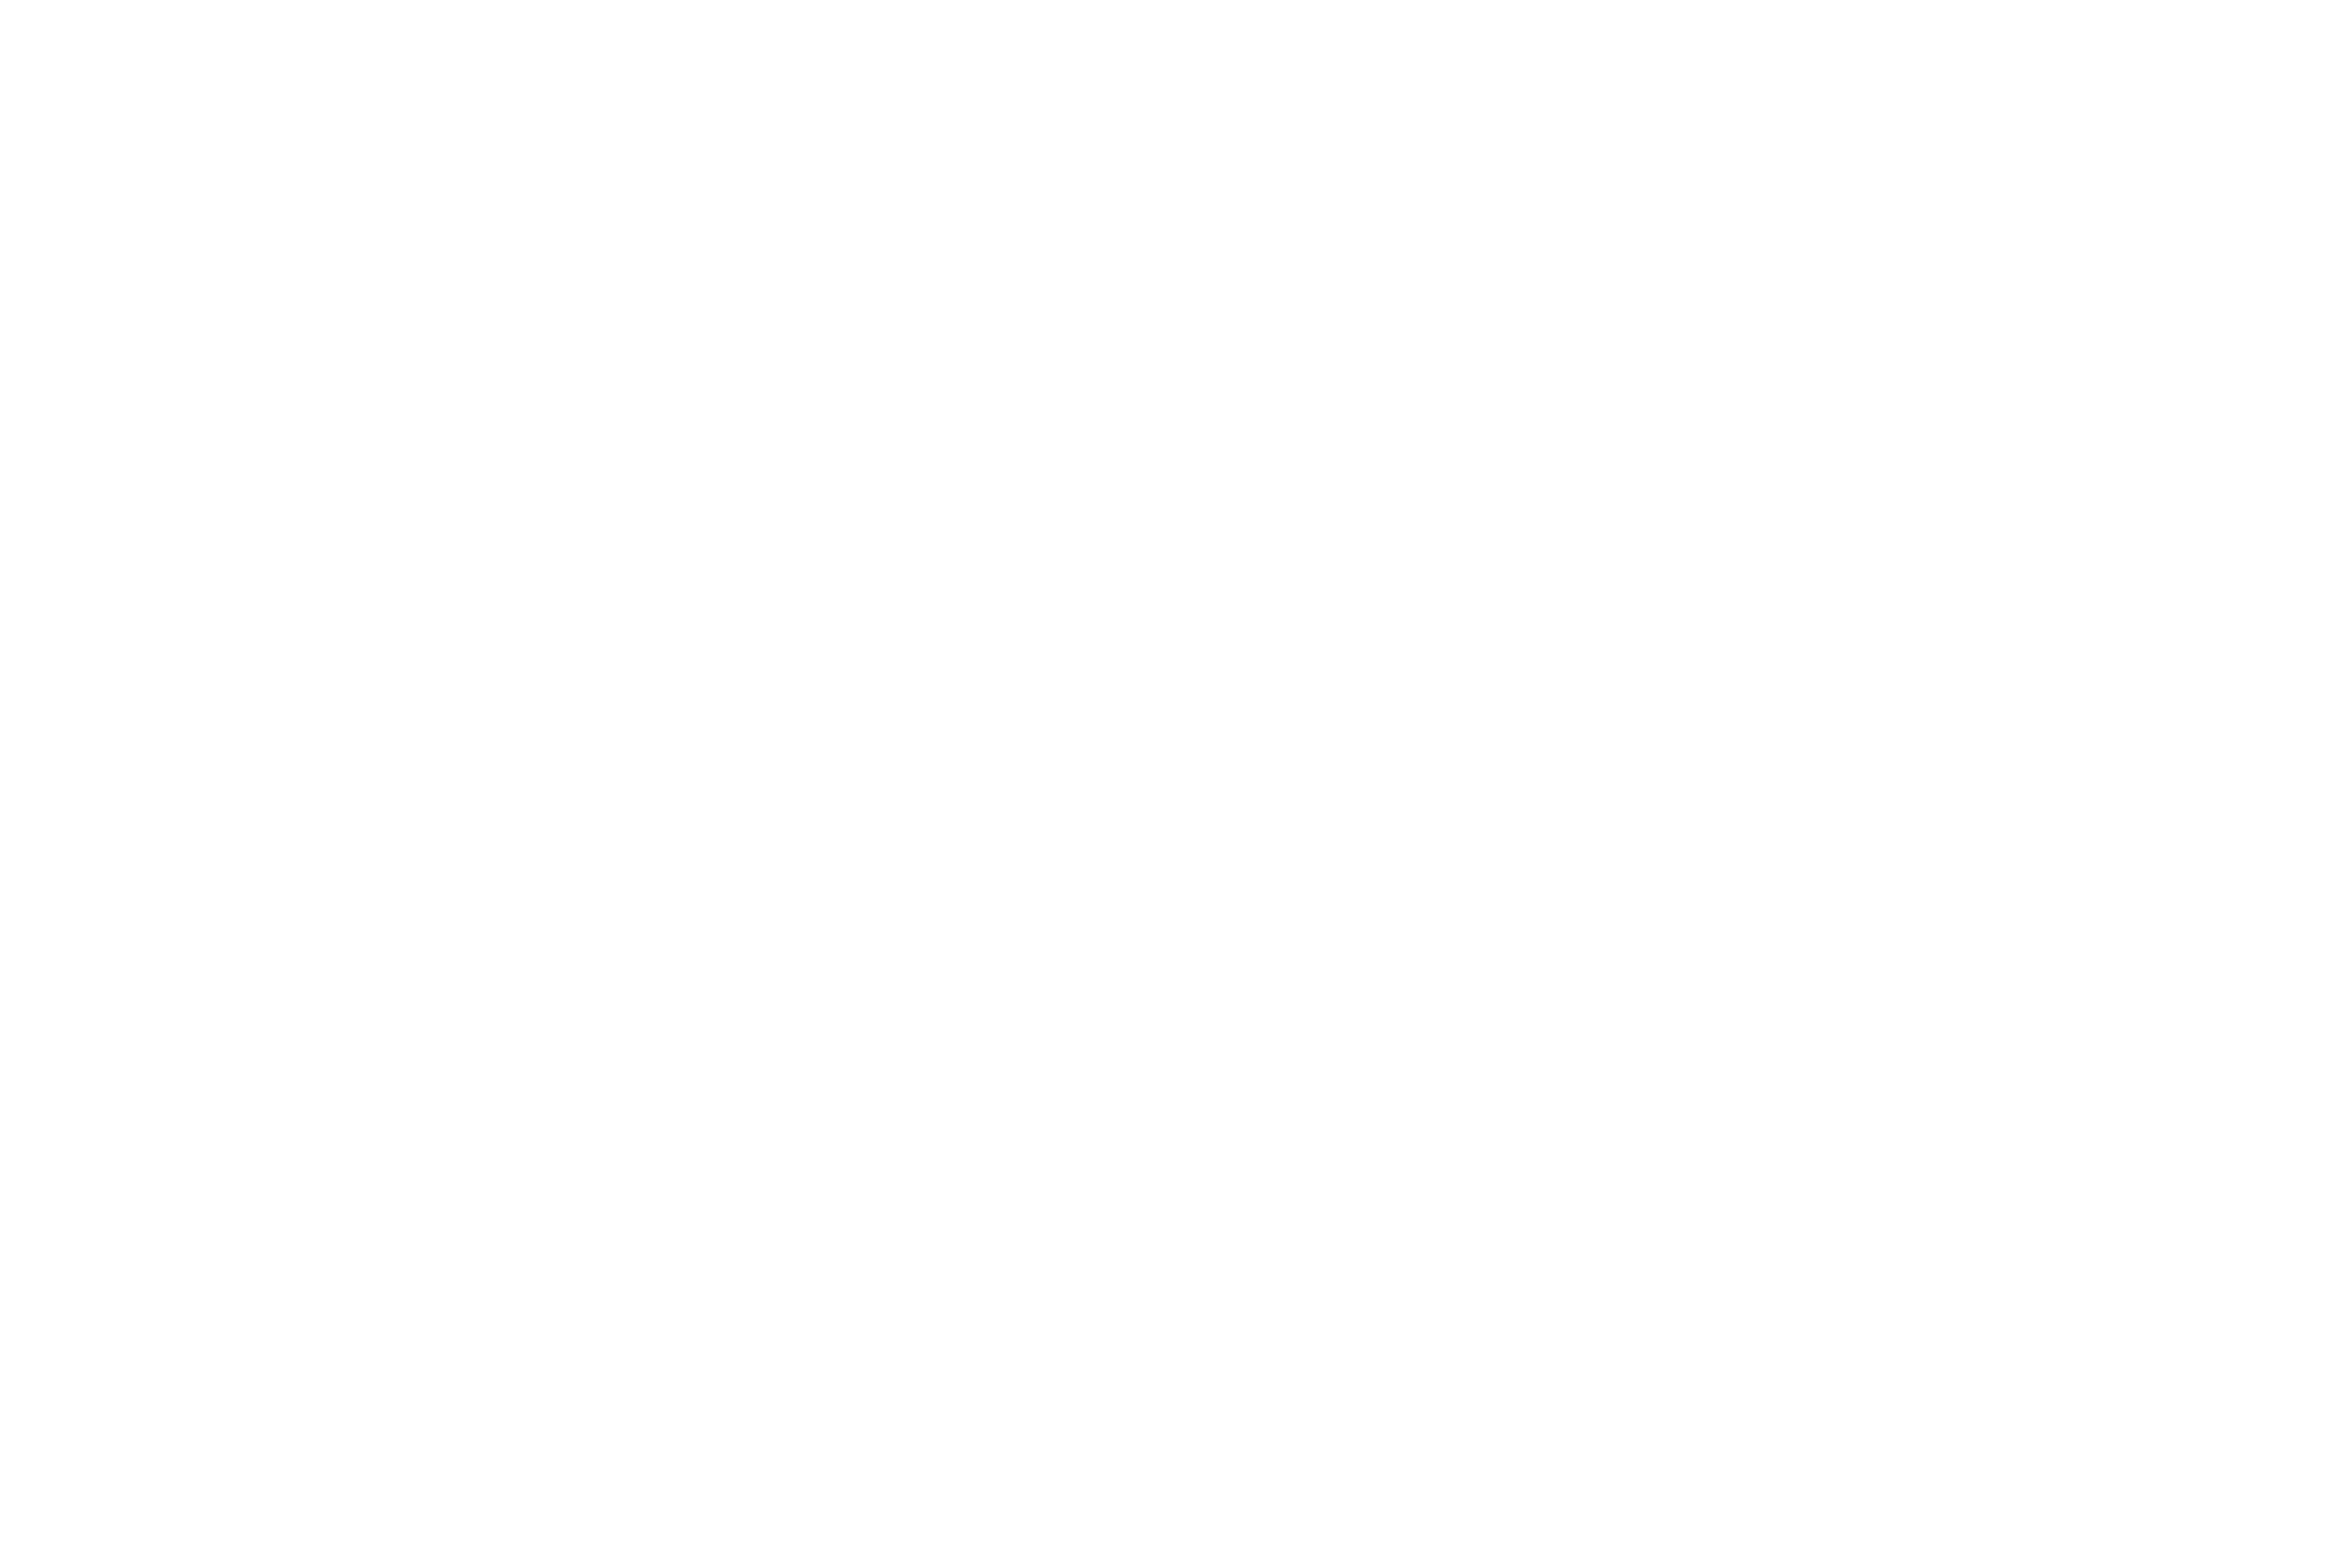

----

The stacked bar chart visually represents the medal distribution for the top 10 countries at the 2024 Olympics. Each bar represents a country, and the different colored segments within the bar show the number of gold, silver, and bronze medals won by that country. This makes it easy to compare the overall medal count and the composition of medals for each country.


----

In [14]:
config_with_code = types.GenerateContentConfig(
    tools=[types.Tool(code_execution=types.ToolCodeExecution())],
    temperature=0.0,
)

response = chat.send_message(
    message="Now plot this as a seaborn chart. Break out the medals too.",
    config=config_with_code,
)

show_response(response)